# Create molecular networks
This notebooks creates a graphml file for the case study data to enable visualizing mol networks in cytoscape

# Download data from zenodo
The ms2deepscore model, case study data and MS2Query annotations are downloaded from zenodo

In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
model_file_name="../../../../data/pytorch/new_corinna_included/trained_models/positive_mode_precursor_mz_ionmode_10000_layers_500_embedding_2024_11_26_11_30_47/ms2deepscore_model.pt"

case_study_spectra_file_name = "case_study_spectra.mgf"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14535374/files/cleaned_spectra_pos_neg_with_numbering.mgf?download=1", case_study_spectra_file_name)


The file ms2deepscore_settings.json already exists, the file won't be downloaded
The file case_study_spectra.mgf already exists, the file won't be downloaded


### Load MS2Deepscore model

In [2]:
from ms2deepscore.models import load_model
model = load_model(model_file_name)

/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

### Create spectral similarity scores
The spectrum file "./cleaned_spectra_pos_neg_with_numbering.mgf" was created in pre_processing_spectra

In [3]:
from matchms.Pipeline import Pipeline, create_workflow
from ms2deepscore import MS2DeepScore

workflow = create_workflow(
    query_filters=[],
    score_computations=[
        [MS2DeepScore, {"model": model}],
        ],
)
pipeline = Pipeline(workflow)
report = pipeline.run(case_study_spectra_file_name)

2025-07-03 11:44:25,611:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.
2025-07-03 11:44:25,613:WARNING:matchms:SpectrumProcessor:No filters have been specified, so spectra were not filtered


Processing spectra: 2909it [00:00, 3335.52it/s]
2909it [00:03, 789.76it/s]


### Create a network
The pipeline.scores contain all the scores. To make a molecular network only some of the similarity scores are stored. They are only stored if the score is at least 0.85 and each node (spectrum) is only connected to the top 5 highest similarity scores and only if it is in the tup 5 of that other spectrum as well. 

This is the common approach for creating molecular networks (exact settings vary) and allows for getting visually pleasing mol networks (preventing giant hairbals).

In [4]:
from matchms.networking import SimilarityNetwork

# Define settings
ms2ds_network = SimilarityNetwork(
    identifier_key="query_spectrum_nr",
    score_cutoff=0.85,  # higher numbers produce more isolated sub-graphs
    max_links=10,  # lower number makes sparser networks
    link_method="mutual",  # mutual means: link is only added if in top list of both nodes
)

# Compute the graph (takes some time)
ms2ds_network.create_network(pipeline.scores, score_name="MS2DeepScore")

### save to graphml

In [5]:
# Export to graphml
ms2ds_network.export_to_graphml("signle_ion_mode_ms2ds_graph_min_0_85_score_10_links.graphml")


### Load into cytoscape

The graphml file can be loaded into cytoscape: https://cytoscape.org/ This is an open source platform for visualizing graphs. 


To recreate the case study results:
- Open cytoscape
- Load in the above created graphml file.
- Load in ms2query annotations as table, see file add_annotations.ipynb. Can be downloaded from https://zenodo.org/records/14535374
- Set style settings (or load in a style file)
- Set up chemviz to visualize chemical information.
- Explore your data!

In [8]:
filtered_edges = [
    (u, v)
    for u, v in ms2ds_network.graph.edges()
    if (u.startswith("pos") and v.startswith("neg")) or (u.startswith("neg") and v.startswith("pos"))
]

In [9]:
filtered_edges

[('neg_1160', 'pos_762'),
 ('neg_1160', 'pos_763'),
 ('neg_1160', 'pos_1559'),
 ('neg_1160', 'pos_1560'),
 ('neg_626', 'pos_511'),
 ('neg_626', 'pos_1308'),
 ('neg_704', 'pos_153'),
 ('neg_704', 'pos_348'),
 ('neg_704', 'pos_950'),
 ('neg_704', 'pos_1145'),
 ('neg_5', 'pos_30'),
 ('neg_5', 'pos_827'),
 ('pos_1295', 'neg_1067'),
 ('neg_1296', 'pos_71'),
 ('neg_1296', 'pos_74'),
 ('neg_1296', 'pos_131'),
 ('neg_1296', 'pos_132'),
 ('neg_1296', 'pos_868'),
 ('neg_1296', 'pos_871'),
 ('neg_1296', 'pos_928'),
 ('neg_1296', 'pos_929'),
 ('pos_1522', 'neg_17'),
 ('pos_1522', 'neg_56'),
 ('pos_1341', 'neg_1159'),
 ('pos_307', 'neg_993'),
 ('pos_928', 'neg_1185'),
 ('pos_928', 'neg_789'),
 ('pos_928', 'neg_519'),
 ('neg_17', 'pos_659'),
 ('neg_17', 'pos_1456'),
 ('neg_17', 'pos_725'),
 ('pos_74', 'neg_1273'),
 ('pos_74', 'neg_1185'),
 ('neg_1159', 'pos_544'),
 ('pos_1296', 'neg_1076'),
 ('neg_1076', 'pos_499'),
 ('pos_659', 'neg_56'),
 ('pos_868', 'neg_1273'),
 ('pos_868', 'neg_1185'),
 ('neg_7

In [7]:
pairs_in_cross_ion_mode_mol_network = [('pos_334', 'neg_144'),
 ('pos_498', 'neg_1067'),
 ('neg_1076', 'pos_499'),
 ('neg_1076', 'pos_1296'),
 ('pos_173', 'neg_316'),
 ('pos_173', 'neg_157'),
 ('pos_173', 'neg_366'),
 ('neg_157', 'pos_113'),
 ('neg_157', 'pos_910'),
 ('neg_157', 'pos_970'),
 ('pos_398', 'neg_343'),
 ('pos_398', 'neg_111'),
 ('pos_99', 'neg_771'),
 ('pos_1131', 'neg_144'),
 ('pos_1195', 'neg_343'),
 ('pos_1195', 'neg_111'),
 ('pos_910', 'neg_316'),
 ('pos_910', 'neg_366'),
 ('pos_896', 'neg_771'),
 ('pos_113', 'neg_316'),
 ('pos_113', 'neg_366'),
 ('pos_401', 'neg_380'),
 ('pos_401', 'neg_316'),
 ('pos_1198', 'neg_380'),
 ('pos_1198', 'neg_316'),
 ('pos_1104', 'neg_771'),
 ('neg_834', 'pos_1363'),
 ('neg_834', 'pos_566'),
 ('neg_316', 'pos_970'),
 ('pos_970', 'neg_366'),
 ('neg_771', 'pos_307'),
 ('pos_1295', 'neg_1067')]

In [13]:
for pair in pairs_in_cross_ion_mode_mol_network:
    for other_pair in filtered_edges:
        if set(pair) == set(other_pair):
            print(pair)


('pos_498', 'neg_1067')
('neg_1076', 'pos_499')
('neg_1076', 'pos_1296')
('pos_1295', 'neg_1067')


In [39]:
from matchms.plotting.spectrum_plots import plot_spectra_mirror
from rdkit import Chem
from rdkit.Chem import Draw
import matchms.similarity as mssim
import numpy as np

def plot_mirror_plot_with_structures(spectrum_ids, ax):
    pos_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_ids[0]][0]
    neg_spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_ids[1]][0]
    print_top5_mz_by_intensity(spectrum_ids[0])
    print_top5_mz_by_intensity(spectrum_ids[1])

    pos_spectrum.set("compound_name", "")
    neg_spectrum.set("compound_name", "")
    ax = plot_spectra_mirror(pos_spectrum, neg_spectrum, grid=False,
                              ax=ax,
                              # max_mz=420,
                              color_top = "#C6DBEF",
                              color_bottom="#FCBBA1"
                             )

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_title(None)
    return ax

In [17]:
filtered_edges
from matchms.importing import load_from_mgf

spectra = list(load_from_mgf(case_study_spectra_file_name))

In [26]:
[spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") =='pos_498'][0]

Spectrum(precursor m/z=613.34, 13 fragments between 375.9 and 613.8)

In [41]:
def print_top5_mz_by_intensity(spectrum_id):
    spectrum = [spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") == spectrum_id][0]

    if spectrum is None or spectrum.peaks is None:
        print("Invalid spectrum.")
        return

    mzs, intensities = spectrum.peaks.mz, spectrum.peaks.intensities

    # Get indices of top 5 intensities
    top_indices = np.argsort(intensities)[-5:][::-1]  # Descending order

    print("Top 5 m/z values by intensity:")
    for idx in top_indices:
        print(f"m/z: {mzs[idx]:.4f}, intensity: {intensities[idx]:.2f}")
    print(spectrum.get("precursor_mz"))
    print(spectrum.get("parent_mass"))

Top 5 m/z values by intensity:
m/z: 613.3399, intensity: 1.00
m/z: 613.4257, intensity: 0.00
m/z: 613.5267, intensity: 0.00
m/z: 613.4810, intensity: 0.00
m/z: 613.6475, intensity: 0.00
613.3399
612.3326235480092
Top 5 m/z values by intensity:
m/z: 613.3595, intensity: 1.00
m/z: 613.3590, intensity: 0.63
m/z: 613.3586, intensity: 0.52
m/z: 613.3604, intensity: 0.49
m/z: 613.3592, intensity: 0.37
613.3601
614.3673764519907


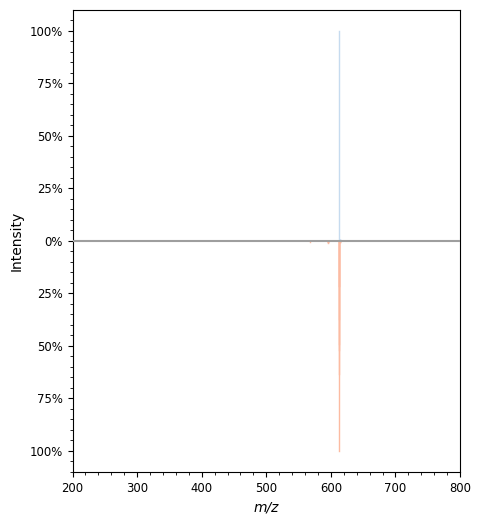

<function __main__.print_top5_mz_by_intensity(spectrum_id)>

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 6))

ax = plot_mirror_plot_with_structures(('pos_498', 'neg_1067'), ax)
plt.show()
print_top5_mz_by_intensity

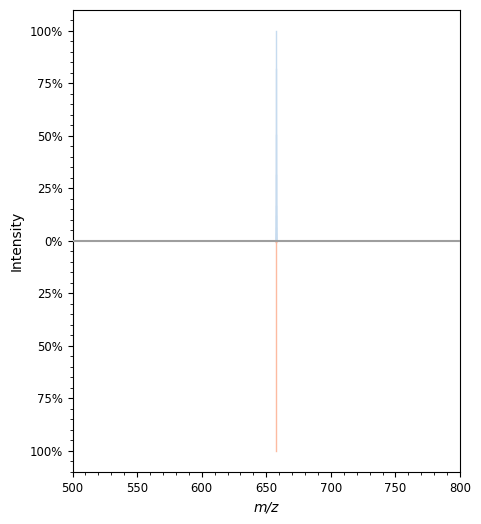

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 6))

ax = plot_mirror_plot_with_structures(('neg_1076', 'pos_499'), ax)
plt.show()

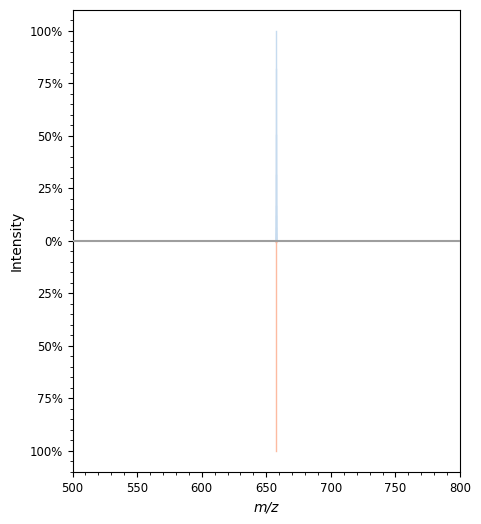

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 6))

ax = plot_mirror_plot_with_structures(('neg_1076', 'pos_1296'), ax)
plt.show()

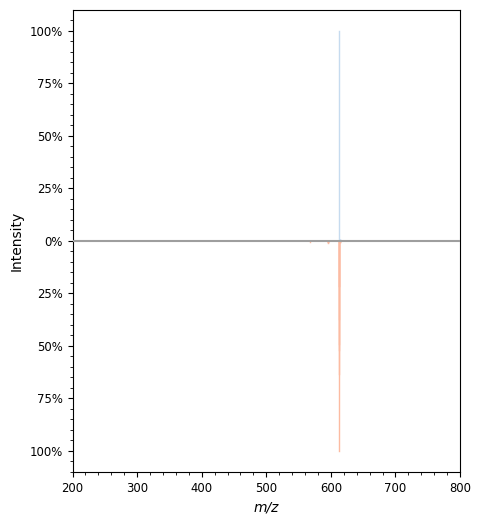

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 6))

ax = plot_mirror_plot_with_structures(('pos_1295', 'neg_1067'), ax)
plt.show()